# 자녀 성장수준 평가 분석

최근 업데이트 : 2022. 2. 11.

Run-all하기 전 "children-growth-update.csv" 먼저 업데이트 할 것

---

## 목차

1. 준비
1. 매월 성장비교 - Ariel vs. Ted
1. 대한민국 평균 대비 성장
1. 백분위 분석

## 1. 준비 - Library, Function prep & DataFrame

In [1]:
# Improt libraries
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')  # 시각화를 위해 'seaborn-whithgrid' 스타일 적용
# plt.rcParams.update({'font.size': 16})

import seaborn as sns
import scipy.stats as ss

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [18]:
# Children birth infomation for data index, month from birth
birth = {'Ariel': pd.Timestamp('2012-01-28'), \
         'Ted': pd.Timestamp('2013-09-28'), \
         'Jua': pd.Timestamp('2014-11-10')}

# MONTHS_FROM_BIRTH 열 생성을 위한 apply 적용 시 사용
def month_diff(row):   
    return (row.DATE - birth[row.PERSON]).days // 30

# 소아청소년 성장도표 읽어오기
def read_table_from_excel(sheet):
    col = ['GENDER', 'AGE_YEAR', 'AGE_MONTH', 'L', 'M', 'S', \
       'PER_1', 'PER_3', 'PER_5', 'PER_10', 'PER_15', 'PER_25', 'PER_50', \
       'PER_75', 'PER_85', 'PER_90', 'PER_95','PER_97', 'PER_99', \
       '-3SD', '-2SD', '-1SD', '0SD', '+1SD', '+2SD', '+3SD']
    

    # table = pd.read_excel('growth-table.xls', sheet_name= sheet, skiprows= 2, header= None)
    table = pd.read_excel('https://raw.githubusercontent.com/jamescbjeon/project/main/children-growth/growth-table.xls', sheet_name= sheet, skiprows= 2, header= None)
    table.columns = col

    table.drop('AGE_YEAR', axis= 1, inplace= True)
    table.set_index('AGE_MONTH', inplace= True)
    
    return table

# 성장도표와 개별 성장 데이터 그래프 생성
def growth_comparison_plot(gender, people, table, col_name):
    # 백분위표에서 필요한 열만 선택
    comparison_col = ['PER_10', 'PER_25', 'PER_50', 'PER_75', 'PER_90']
    
    table.loc[table.GENDER == gender, comparison_col].plot(linestyle= ':')
    for person in people:
        df.loc[df.PERSON == person, col_name].dropna(axis=0).plot(marker='.', figsize= (8, 6))
    
    ylabeldict = {'HEIGHT': 'Height (cm)', 'WEIGHT': 'Weight (kg)', 'BMI': 'Body Mass Index', 'HEAD': 'Head-around (cm)'}
    
    plt.title(col_name)
    plt.legend(comparison_col + people)
    plt.xlabel('Months from birth')
    plt.ylabel(ylabeldict[col_name])
    plt.show()

# 개별 성장 데이터 내 백분위값 변환
def percentile(row, item):
    table_dict = {'HEIGHT': height, 'WEIGHT': weight, 'BMI': bmi}
    
    mfb = row.MONTHS_FROM_BIRTH
    
    x= row.loc[item]
    l = table_dict[item].loc[(table_dict[item].index == mfb) & (table_dict[item].GENDER == row.GENDER), :].L
    m = table_dict[item].loc[(table_dict[item].index == mfb) & (table_dict[item].GENDER == row.GENDER), :].M
    s = table_dict[item].loc[(table_dict[item].index == mfb) & (table_dict[item].GENDER == row.GENDER), :].S

    Z = ((x / m) ** l - 1) / (l * s)
    perc = ss.norm.cdf(Z) * 100
    
    try:
        return perc[0]
    except:
        return np.nan

In [8]:
# 자녀 성장값 호출
df = pd.read_csv('children-growth-update.csv')

df.DATE = pd.to_datetime(df.DATE)  # Change dtype from string to pandas datetime
df['MONTHS_FROM_BIRTH'] = df.apply(month_diff, axis=1)  # Create new column, months from birth
df['BMI'] = df.WEIGHT / df.HEIGHT / df.HEIGHT * 10000  # Create new column, BMI - Body Mass Index
df['GENDER'] = df.PERSON.map({'Ariel': 2, 'Ted': 1, 'Jua': 2})  # Create new column, Male = 1, Female = 2

df.set_index('MONTHS_FROM_BIRTH', inplace=True)
df.sort_index(inplace= True)

df.head()

,PERSON,DATE,WEIGHT,HEIGHT,HEAD,BMI,GENDER
MONTHS_FROM_BIRTH,,,,,,,
12,Ted,2014-09-23,11.3,77.3,NaN,18.911216,1
17,Ted,2015-03-19,12.8,80.8,49.5,19.605921,1
18,Ted,2015-04-19,12.0,82.0,49.0,17.846520,1
18,Ted,2015-04-10,13.0,83.0,NaN,18.870663,1
20,Ted,2015-06-03,13.2,82.0,NaN,19.631172,1


정리된 측정 결과이다. 각 열의 정보는 아래와 같다.

* MONTHS_FROM_BIRTH : 생후개월 (측정일 - 출생일의 월 변환)
* PERSON : 측정 대상 - 본 데이터에는 3명 존재 (Ariel, Ted, Jua)
* DATE : 측정 일자
* WEIGHT : 몸무게 (kg)
* HEIGHT : 키 (cm)
* HEAD : 머리둘레 (cm)
* BMI : Body Mass Index (몸무게 / 키^2)
* GENDER : 성별 (남자1, 여자2)

In [4]:
df.shape

(94, 7)

In [5]:
df.dtypes

PERSON            object
DATE      datetime64[ns]
WEIGHT           float64
HEIGHT           float64
HEAD             float64
BMI              float64
GENDER             int64
dtype: object

In [6]:
df.describe(include= 'all')

,PERSON,DATE,WEIGHT,HEIGHT,HEAD,BMI,GENDER
count,94,94,94.000000,94.000000,43.000000,94.000000,94.000000
unique,3,62,NaN,NaN,NaN,NaN,NaN
top,Ariel,2019-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,51,3,NaN,NaN,NaN,NaN,NaN
first,NaN,2014-06-26 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2021-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,23.312766,112.318085,50.253488,17.807790,1.638298
std,NaN,NaN,8.766336,17.979690,1.717466,1.461738,0.483070
min,NaN,NaN,11.300000,77.300000,46.000000,15.304496,1.000000
25%,NaN,NaN,16.425000,97.000000,49.250000,16.381796,1.000000


## 2. 매월 성장 비교

### 2.1 키

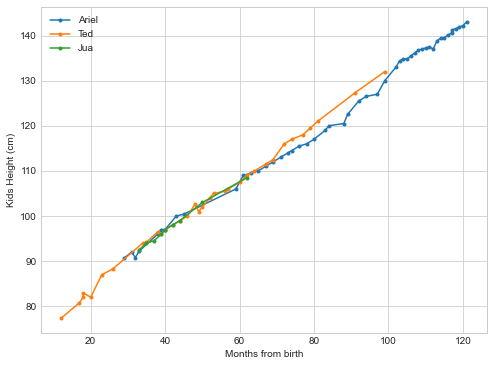

In [9]:
for person in birth:
    df.loc[df.PERSON == person, 'HEIGHT'].plot(marker='.', figsize= (8, 6))

plt.legend(birth)
plt.xlabel('Months from birth')
plt.ylabel('Kids Height (cm)')
plt.show()

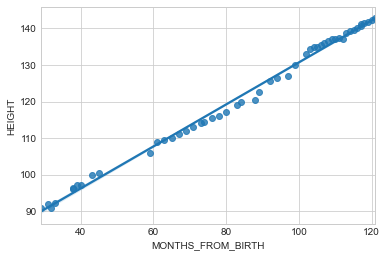

In [10]:
sns.regplot(data= df.loc[df.PERSON == 'Ariel', :].reset_index(), x= 'MONTHS_FROM_BIRTH', y='HEIGHT')

키 성장은 대체적으로 매월 일정량 성장하는 편이며, 선형성이 분명하다.
선형회귀분석 시 확인되는 Coef를 비교하면 성장속도 비교가 가능하다.

In [11]:
# Apply linear model in height dataset
lr = LinearRegression()

df.reset_index(inplace=True)

for person in birth:
    x = df.loc[df.PERSON == person, 'MONTHS_FROM_BIRTH']
    y = df.loc[df.PERSON == person, 'HEIGHT']
    
    lr.fit(x.values.reshape(-1,1), y)
    yhat = lr.predict(x.values.reshape(-1,1))
    
    print('********')
    print(person)
    print('coefficient: ', lr.coef_)
    print('intercept: ', lr.intercept_)
    print('r-squared: ', r2_score(y, yhat))

********
Ariel
coefficient:  [0.57582542]
intercept:  73.13911106144437
r-squared:  0.9946664826829679
********
Ted
coefficient:  [0.60672036]
intercept:  71.87631619954243
r-squared:  0.9953421281348449
********
Jua
coefficient:  [0.55939033]
intercept:  74.31254379817801
r-squared:  0.9936763959131122


### 2.2 몸무게

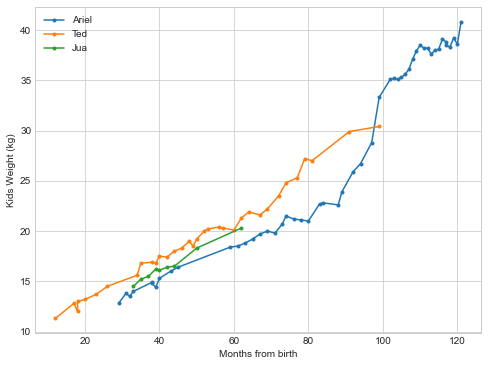

In [12]:
df.set_index('MONTHS_FROM_BIRTH', inplace=True)

for person in birth:
    df.loc[df.PERSON == person, 'WEIGHT'].plot(marker='.', figsize= (8, 6))

plt.legend(birth)
plt.xlabel('Months from birth')
plt.ylabel('Kids Weight (kg)')
plt.show()

### 2.3 BMI

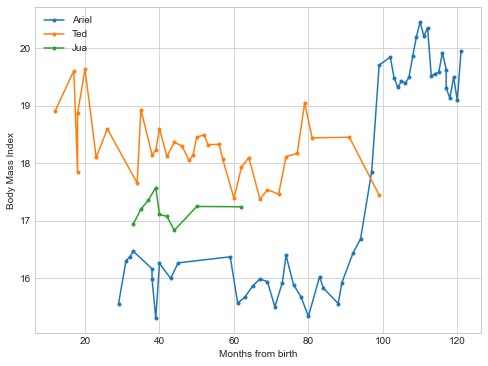

In [13]:
for person in birth:
    df.loc[df.PERSON == person, 'BMI'].plot(marker='.', figsize= (8, 6))

plt.legend(birth)
plt.xlabel('Months from birth')
plt.ylabel('Body Mass Index')
plt.show()

### 2.4 머리둘레
90개월 이후는 업데이트 미실시

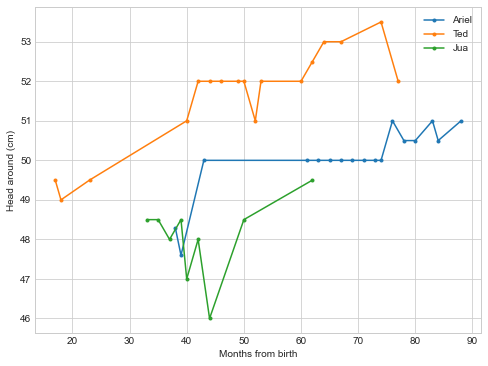

In [14]:
for person in birth:
    df.loc[df.PERSON == person, 'HEAD'].dropna(axis= 0).plot(marker='.', figsize= (8, 6))

plt.legend(birth)
plt.xlabel('Months from birth')
plt.ylabel('Head around (cm)')
plt.show()

## 3. 대한민국 평균 대비 성장

질병관리청 - 소아청소년 성장 수준 통계 (http://www.cdc.go.kr/contents.es?mid=a20303030400)

In [19]:
height = read_table_from_excel('연령별 신장')
weight = read_table_from_excel('연령별 체중')
bmi = read_table_from_excel('연령별 체질량지수')
head = read_table_from_excel('연령별 머리둘레')

In [20]:
height.head()

,GENDER,L,M,S,PER_1,PER_3,PER_5,PER_10,PER_15,PER_25,...,PER_95,PER_97,PER_99,-3SD,-2SD,-1SD,0SD,+1SD,+2SD,+3SD
AGE_MONTH,,,,,,,,,,,,,,,,,,,,,
0,1,1.0,49.8842,0.0380,45.5,46.3,46.8,47.5,47.9,48.6,...,53.0,53.4,54.3,44.2,46.1,48.0,49.9,51.8,53.7,55.6
1,1,1.0,54.7244,0.0356,50.2,51.1,51.5,52.2,52.7,53.4,...,57.9,58.4,59.3,48.9,50.8,52.8,54.7,56.7,58.6,60.6
2,1,1.0,58.4249,0.0342,53.8,54.7,55.1,55.9,56.4,57.1,...,61.7,62.2,63.1,52.4,54.4,56.4,58.4,60.4,62.4,64.4
3,1,1.0,61.4292,0.0333,56.7,57.6,58.1,58.8,59.3,60.1,...,64.8,65.3,66.2,55.3,57.3,59.4,61.4,63.5,65.5,67.6
4,1,1.0,63.8860,0.0326,59.0,60.0,60.5,61.2,61.7,62.5,...,67.3,67.8,68.7,57.6,59.7,61.8,63.9,66.0,68.0,70.1


### 3.1 Girl - Ariel

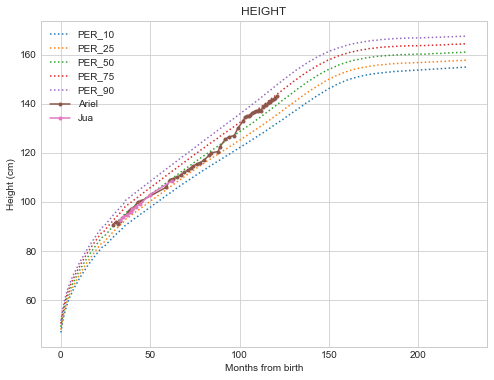

In [21]:
growth_comparison_plot(2, ['Ariel', 'Jua'], height, 'HEIGHT')

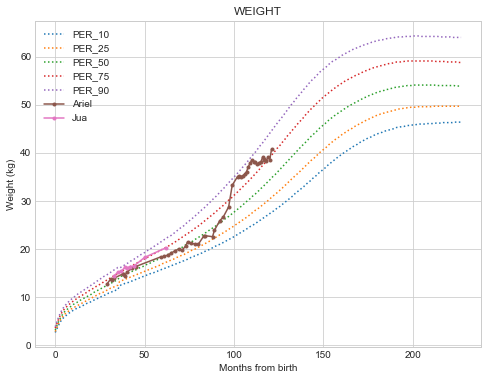

In [22]:
growth_comparison_plot(2, ['Ariel', 'Jua'], weight, 'WEIGHT')

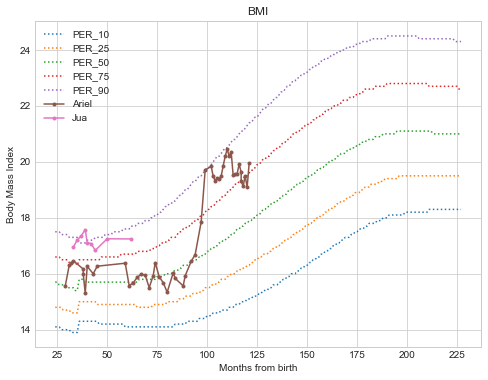

In [23]:
growth_comparison_plot(2, ['Ariel', 'Jua'], bmi, 'BMI')

### 3.2 Boy - Ted

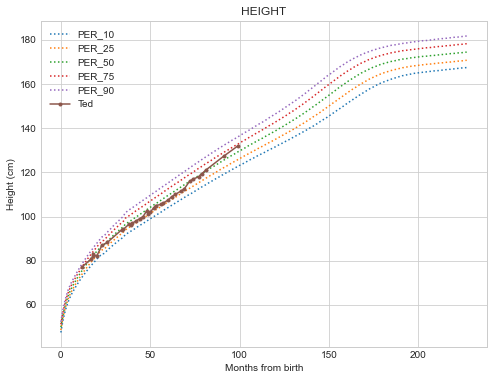

In [25]:
growth_comparison_plot(1, ['Ted'], height, 'HEIGHT')

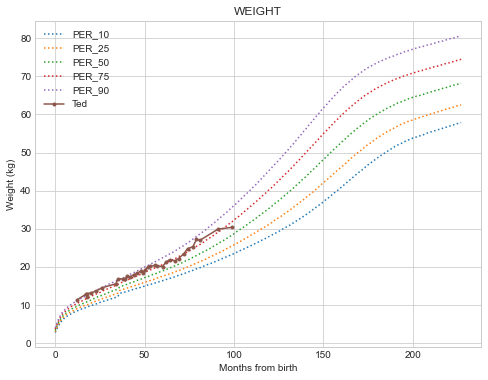

In [26]:
growth_comparison_plot(1, ['Ted'], weight, 'WEIGHT')

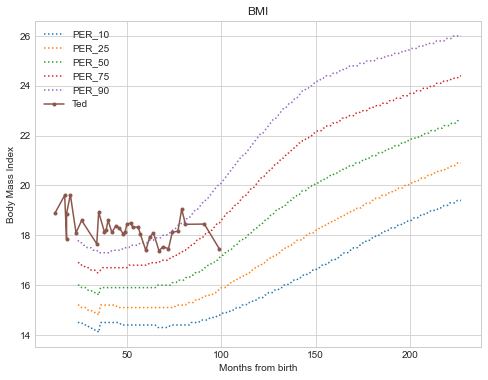

In [27]:
growth_comparison_plot(1, ['Ted'], bmi, 'BMI')

## 4. 백분위 분석

성장도표의 L, M, S 값을 활용하여 아래처럼 측정 결과인 x에 대해 Z-score를 아래의 공식으로 계산 가능하다.
```
Z = (((x / M) ** L) - 1) / (L * S)
```

계산된 Z-score는 scipy.stats 라이브러리의 norm.cdf를 활용하여 누적 백분위 값으로 변환하도록 한다.

In [29]:
df.reset_index(inplace=True)

df['HEIGHT_PER'] = df.apply(percentile, item= 'HEIGHT', axis='columns')
df['WEIGHT_PER'] = df.apply(percentile, item= 'WEIGHT', axis='columns')
df['BMI_PER'] = df.apply(percentile, item= 'BMI', axis='columns')

### 4.1 Percentile - Ariel

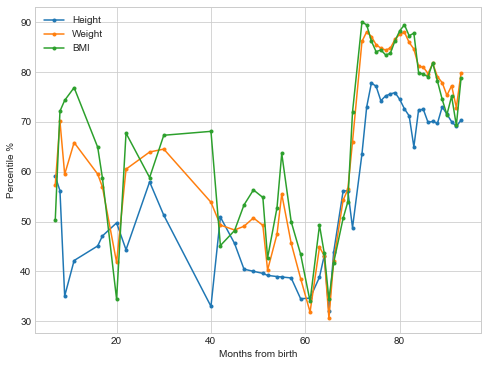

In [31]:
df.loc[df.PERSON == 'Ariel', ['HEIGHT_PER', 'WEIGHT_PER', 'BMI_PER']].plot(marker= '.', figsize= (8, 6))

plt.legend(['Height', 'Weight', 'BMI'])
plt.xlabel('Months from birth')
plt.ylabel('Percentile %')
plt.show()

### 4.2 Percentile - Ted

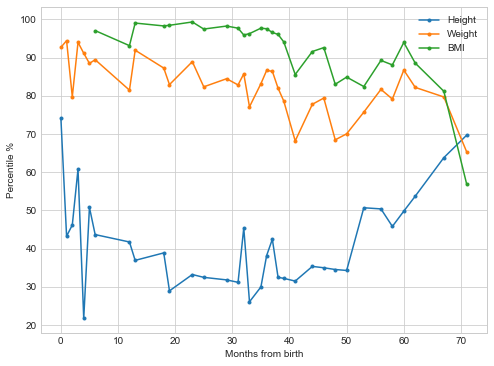

In [32]:
df.loc[df.PERSON == 'Ted', ['HEIGHT_PER', 'WEIGHT_PER', 'BMI_PER']].plot(marker= '.', figsize= (8, 6))

plt.legend(['Height', 'Weight', 'BMI'])
plt.xlabel('Months from birth')
plt.ylabel('Percentile %')
plt.show()

### 4.3 Percentile - Jua

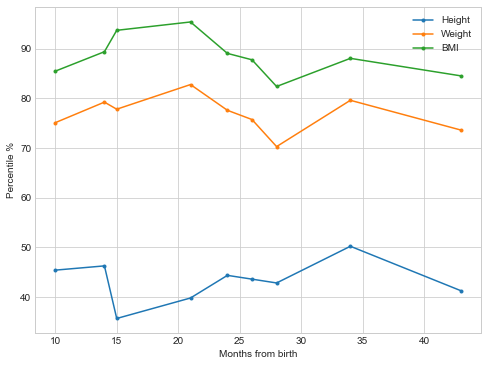

In [33]:
df.loc[df.PERSON == 'Jua', ['HEIGHT_PER', 'WEIGHT_PER', 'BMI_PER']].plot(marker= '.', figsize= (8, 6))

plt.legend(['Height', 'Weight', 'BMI'])
plt.xlabel('Months from birth')
plt.ylabel('Percentile %')
plt.show()